# Gaussian Naive Bayes - Explained

In [122]:
# Gaussian Naive Bayes Classification
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

%matplotlib inline
data = pd.read_csv('diabetes.csv')

X = data.drop(columns=['Outcome'],axis=1)
Y = data['Outcome']


In [123]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [124]:
data.isin([0]).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

## EDA

In [125]:
def univariateAnalysis_numeric1(column):
    print("\nDescription of " + column)
    print("----------------------------------------------------------------------------")
    print(data[column].describe(),end=' ')

    print("\nCentral values of " + column)
    print("----------------------------------------------------------------------------")
    #Central values 
    print('\nMinimum : ', data[column].min(),end=' ')
    print('\nMaximum : ', data[column].max(),end=' ')
    print('\nMean value : ', data[column].mean(),end=' ')
    print('\nMedian value : ', data[column].median(),end=' ')
    print('\nStandard deviation : ', data[column].std(),end=' ')
    print('\nNull values : ', data[column].isnull().any(),end=' ')
    print('\nNull values : ', data[column].isnull().sum().sum(),end=' ')

    print("\nQuartile of " + column)
    print("----------------------------------------------------------------------------")
    #Quartiles
    Q1=data[column].quantile(q=0.25)
    Q3=data[column].quantile(q=0.75)
    print('1st Quartile (Q1) is: ', Q1)
    print('3st Quartile (Q3) is: ', Q3)
    print('Interquartile range (IQR) is ', stats.iqr(data[column]))

    print("\nOutlier detection from Interquartile range (IQR) " + column)
    print("----------------------------------------------------------------------------")
    L_outliers=Q1-1.5*(Q3-Q1)
    U_outliers=Q3+1.5*(Q3-Q1)
    print('\nLower outliers range: ', L_outliers)
    print('\nUpper outliers range: ', U_outliers)
    print('Number of outliers in upper : ', data[data[column]>U_outliers][column].count())
    print('Number of outliers in lower : ', data[data[column]<L_outliers][column].count())
    print('% of Outlier in upper: ',round(data[data[column]>U_outliers][column].count()*100/len(data)), '%')
    print('% of Outlier in lower: ',round(data[data[column]<L_outliers][column].count()*100/len(data)), '%')

    #boxplot
    plt.figure()
    print("\nBoxPlot of " + column)
    print("----------------------------------------------------------------------------")
    ax = sns.boxplot(x=data[column])
    plt.show()
    
    #distplot
    plt.figure()
    print("\ndistplot of " + column)
    print("----------------------------------------------------------------------------")
    sns.distplot(data[column])
    plt.show()
    
    #histogram
    plt.figure()
    print("\nHistogram of " + column)
    print("----------------------------------------------------------------------------")
    sns.distplot(data[column], kde=False, color='red')
    plt.show()

    # Plotting mean, median and mode
    plt.figure()
    print("\nHistogram with mean, median and mode of " + column)
    print("----------------------------------------------------------------------------")
    mean=data[column].mean()
    median=data[column].median()
    mode=data[column].mode()

    print('Mean: ',mean,'\nMedian: ',median,'\nMode: ',mode[0])
    plt.hist(data[column],bins=100,color='lightblue') #Plot the histogram
    plt.axvline(mean,color='green',label='Mean')     # Draw lines on the plot for mean median and the two modes we have in GRE Score
    plt.axvline(median,color='blue',label='Median')
    plt.axvline(mode[0],color='red',label='Mode1')
    plt.legend()              # Plot the legend
    plt.show()

    print("\nSkewness of " + column)
    print("----------------------------------------------------------------------------")

    print(data[column].skew())
    
    # fig, (ax1)=plt.subplots(1,0,figsize=(13,5))

In [126]:
df_num = data.select_dtypes(include = ['float64', 'int64'])
lstnumericcolumns = list(df_num.columns.values)
len(lstnumericcolumns)


9

In [127]:
# for x in lstnumericcolumns:
#     univariateAnalysis_numeric1(x)

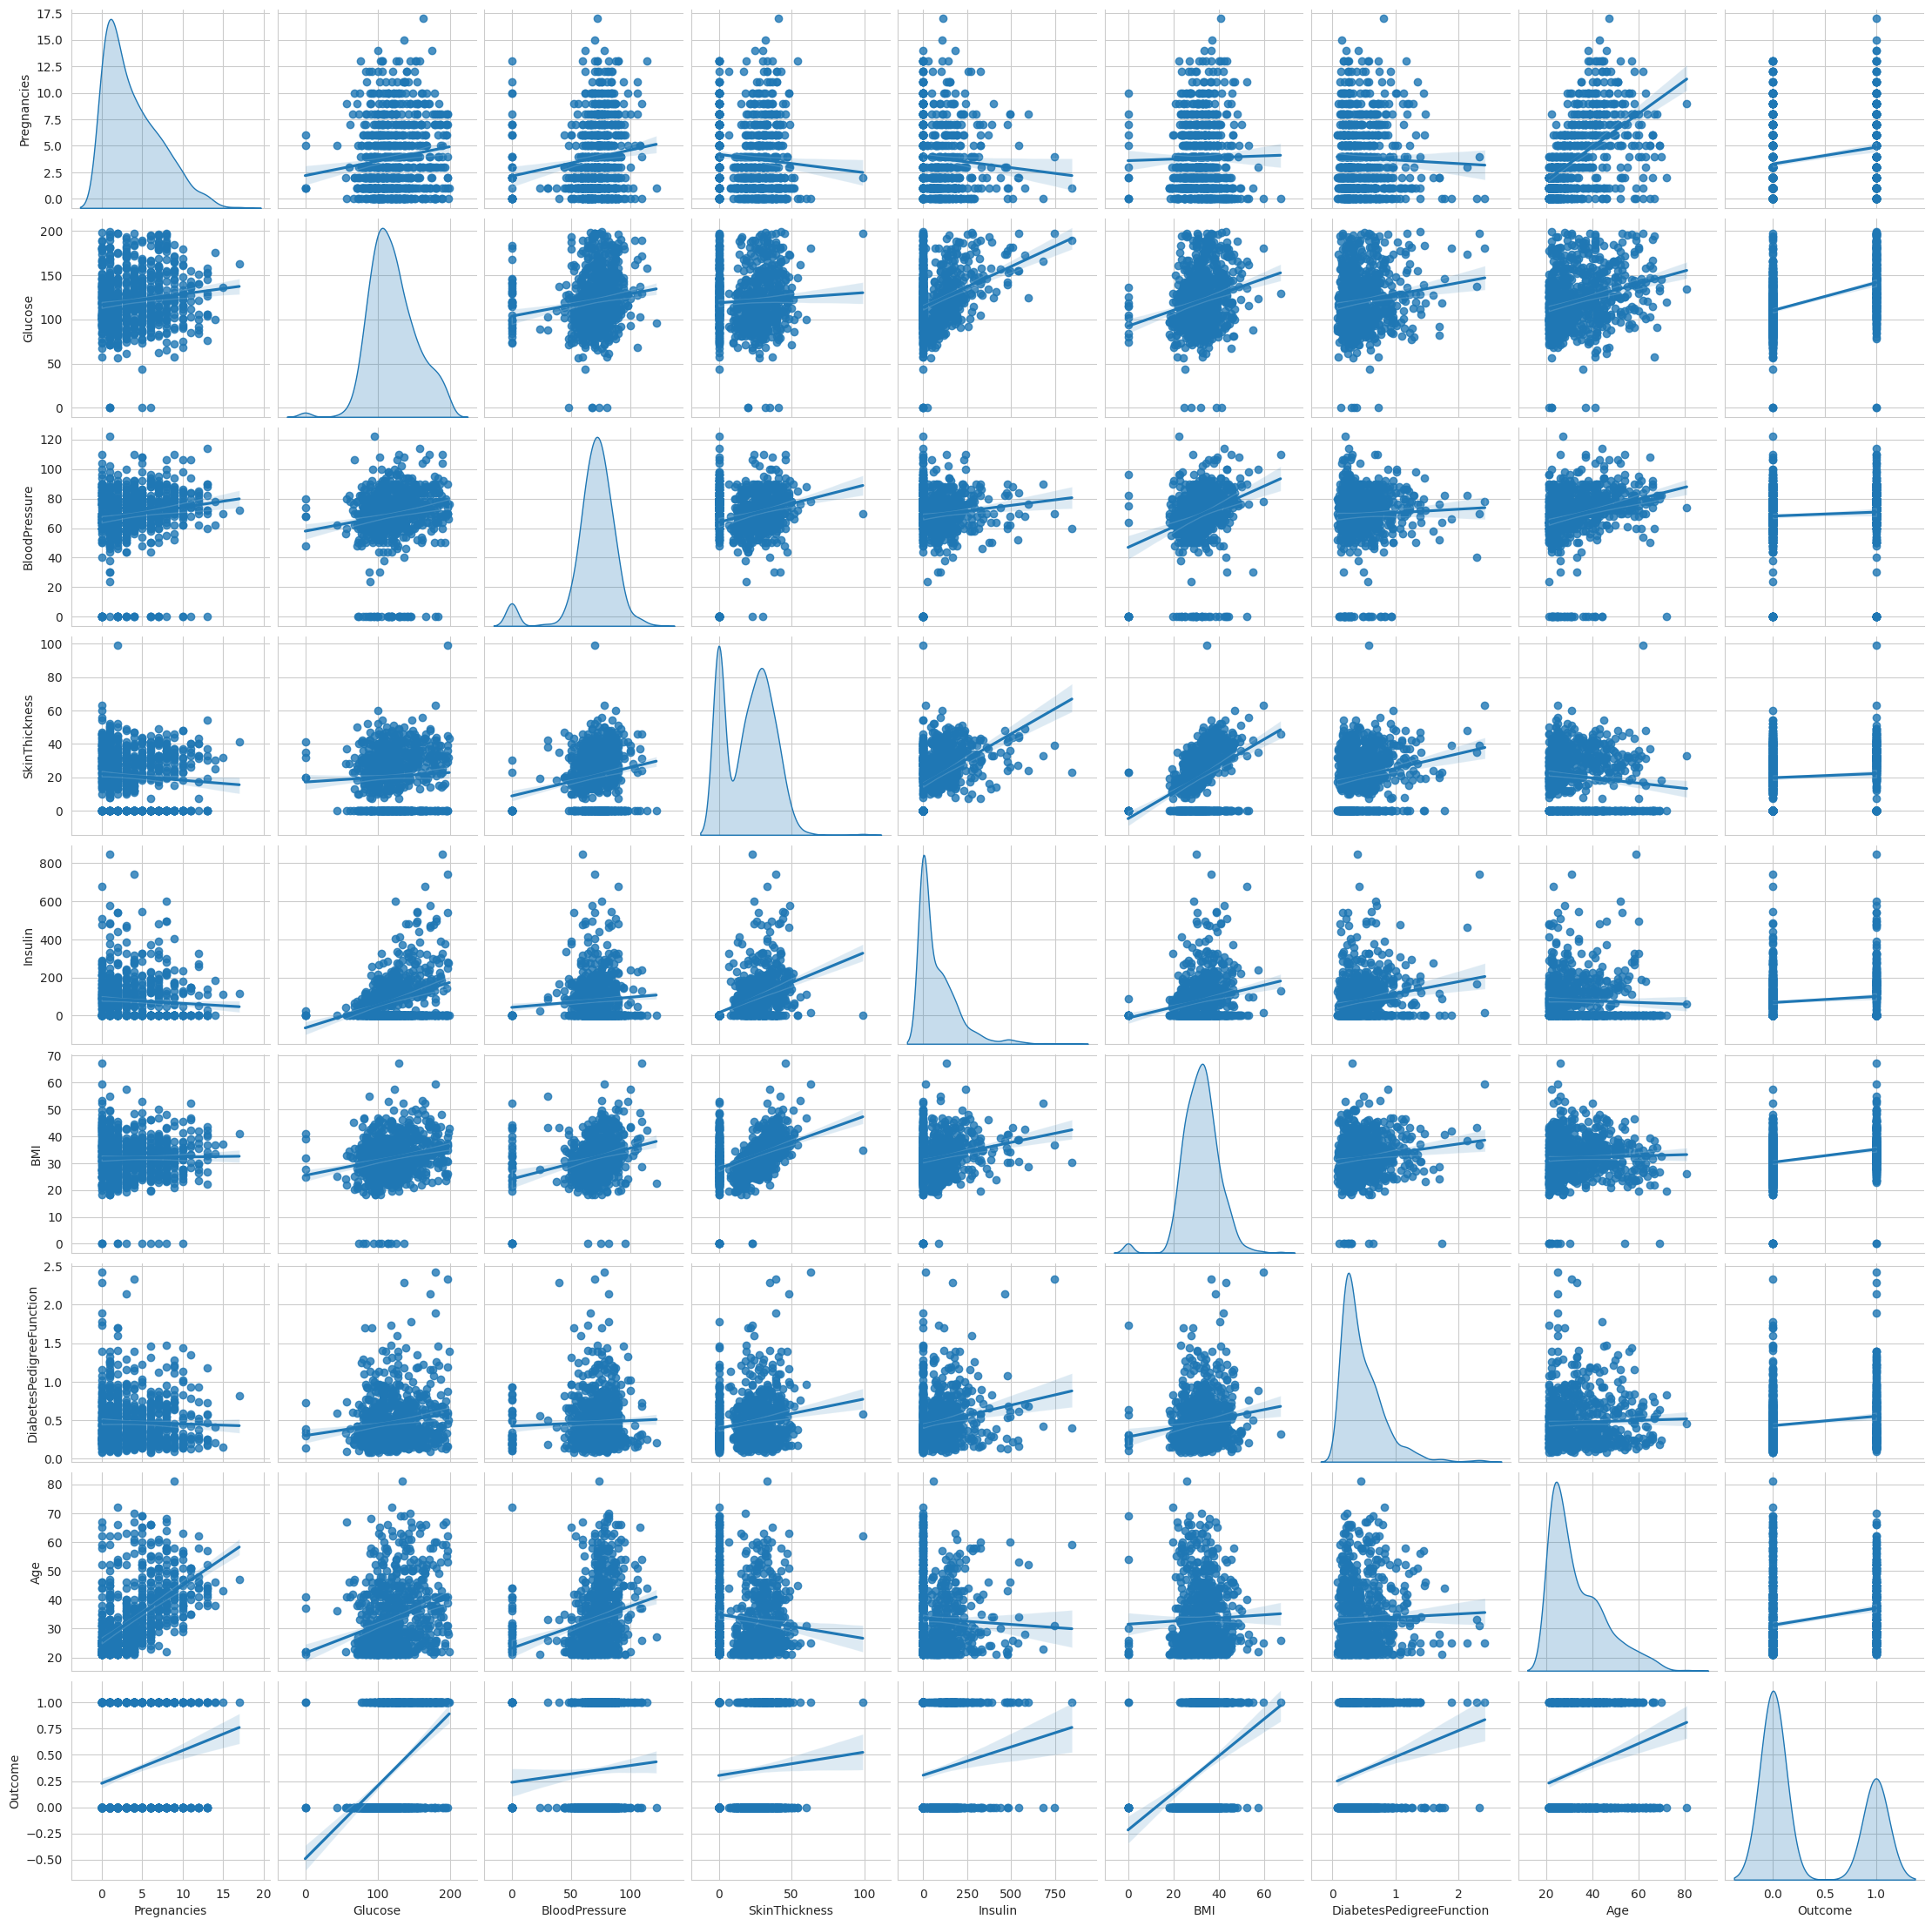

In [128]:
sns.pairplot(data,diag_kind='kde',kind='reg')

In [129]:
#correlation matrix
data.corr().T

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


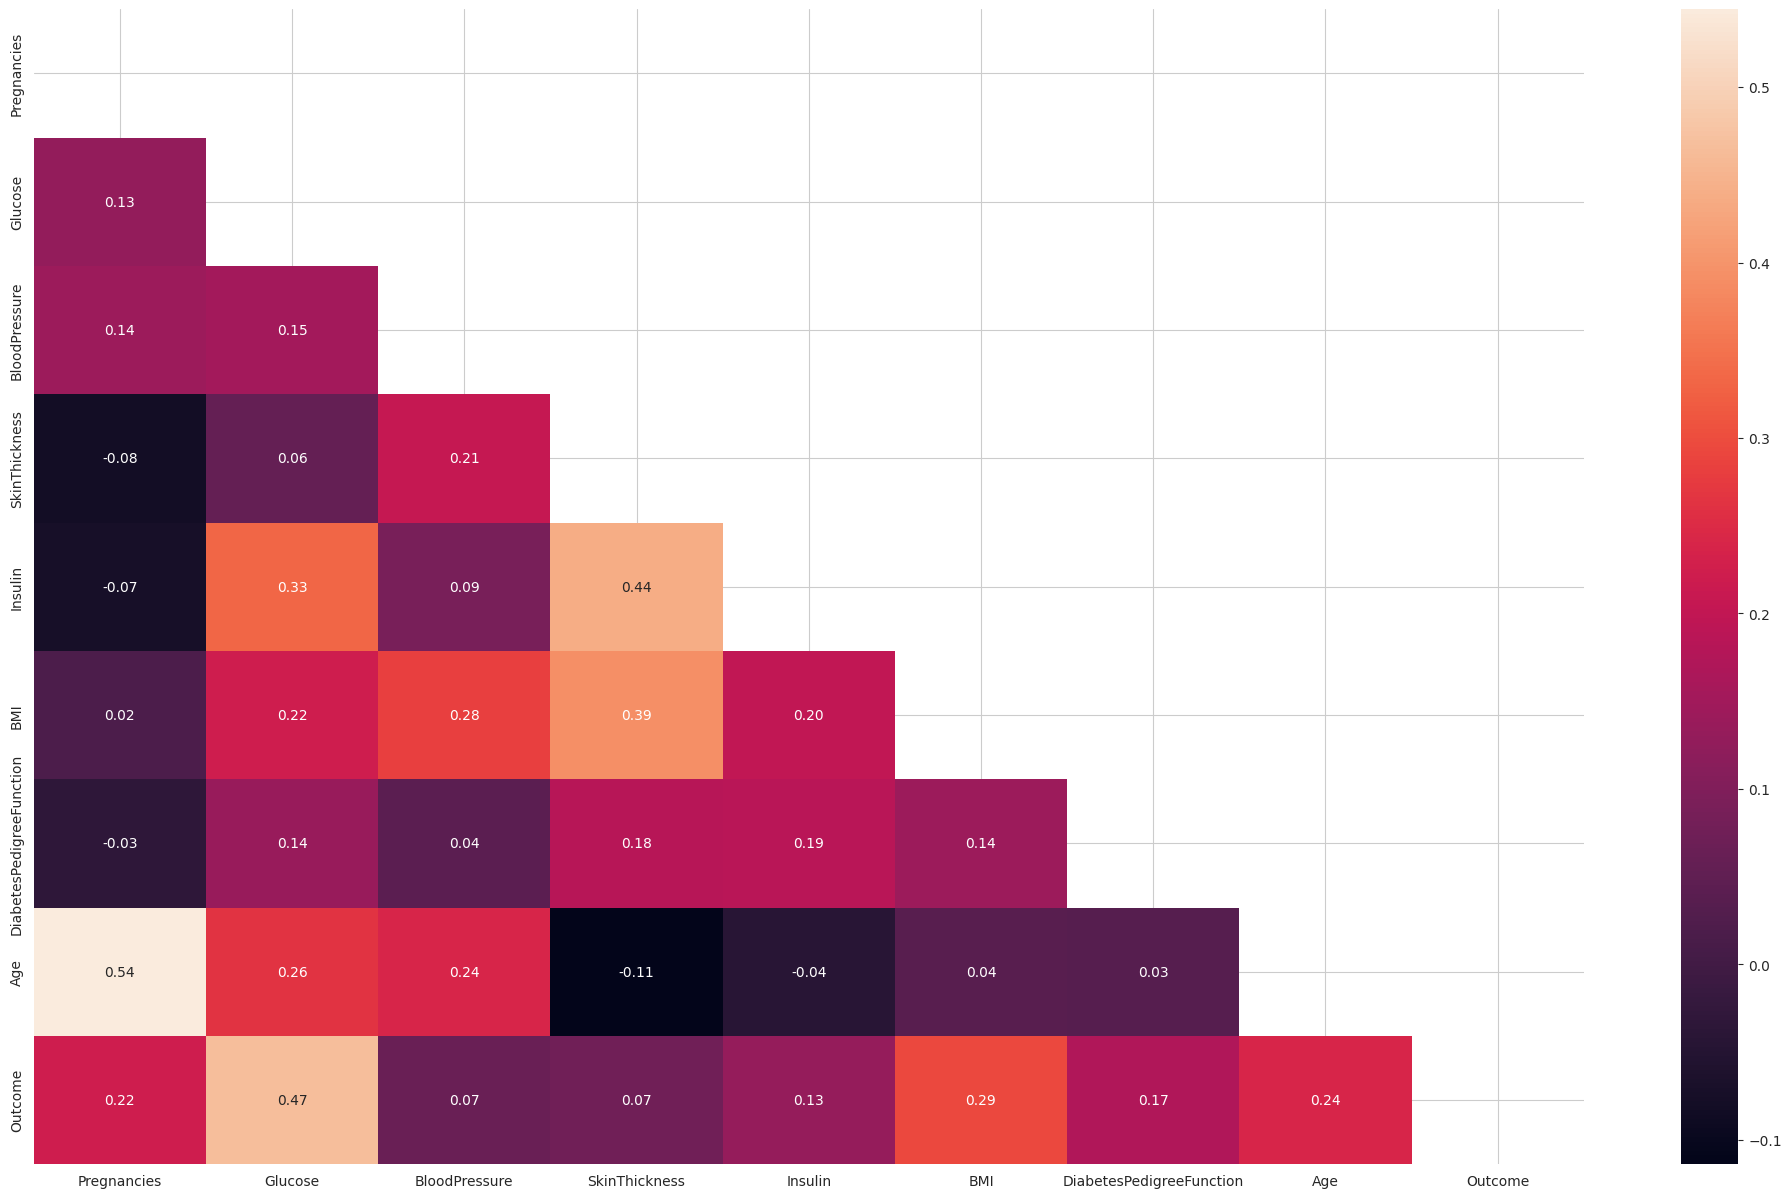

In [130]:
corr = df_num.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=np.bool)) 
fig = plt.subplots(figsize=(25, 15))
sns.heatmap(df_num.corr(), annot=True,fmt='.2f',mask=mask)
plt.show()

In [131]:
# Let us see the significant correlation either negative or positive among independent attributes..
c = data.corr().abs() # Since there may be positive as well as -ve correlation
s = c.unstack() # 
so = s.sort_values(ascending=False) # Sorting according to the correlation
so=so[(so<1) & (so>0.3)].drop_duplicates().to_frame() # Due to symmetry.. dropping duplicate entries.
so.columns = ['correlation']
so

,,correlation
Pregnancies,Age,0.544341
Glucose,Outcome,0.466581
Insulin,SkinThickness,0.436783
BMI,SkinThickness,0.392573
Glucose,Insulin,0.331357


In [132]:
model = GaussianNB()
cv_scores = cross_val_score(model, X, Y, cv=5)
    
print(model, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

GaussianNB()  mean accuracy:  75.134 % std:  0.035 %


In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


In [134]:
# Creating dataframe with 0 values in any cell
data1 = data.copy()
data1 = data1.drop(columns=['Outcome'],axis=1)
data1 = data1[(data1 == 0).any(axis=1)]
data1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
4,0,137,40,35,168,43.1,2.288,33
5,5,116,74,0,0,25.6,0.201,30
...,...,...,...,...,...,...,...,...
761,9,170,74,31,0,44.0,0.403,43
762,9,89,62,0,0,22.5,0.142,33
764,2,122,70,27,0,36.8,0.340,27
766,1,126,60,0,0,30.1,0.349,47


In [135]:
#Conditional Formatting in pandas - Colouring cells having 0 (zero) values

data1.style.applymap(lambda x: 'background-color : red' if x==0 else '')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.600000,0.627000,50
1,1,85,66,29,0,26.600000,0.351000,31
2,8,183,64,0,0,23.300000,0.672000,32
4,0,137,40,35,168,43.100000,2.288000,33
5,5,116,74,0,0,25.600000,0.201000,30
7,10,115,0,0,0,35.300000,0.134000,29
9,8,125,96,0,0,0.000000,0.232000,54
10,4,110,92,0,0,37.600000,0.191000,30
11,10,168,74,0,0,38.000000,0.537000,34
12,10,139,80,0,0,27.100000,1.441000,57


## Imputing 0 (zero) values with mean

In [136]:
from sklearn.impute import SimpleImputer
rep_0 = SimpleImputer(missing_values=0, strategy="mean")
cols = X_train.columns
X_train = pd.DataFrame(rep_0.fit_transform(X_train))
X_test = pd.DataFrame(rep_0.fit_transform(X_test))

X_train.columns = cols
X_test.columns = cols

X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,4.539474,151.0,90.0,46.000000,159.97193,42.1,0.371,21.0
1,1.000000,83.0,68.0,29.411458,159.97193,18.2,0.624,27.0
2,2.000000,122.0,70.0,27.000000,159.97193,36.8,0.340,27.0
3,4.000000,146.0,78.0,29.411458,159.97193,38.5,0.520,67.0
4,4.539474,123.0,72.0,29.411458,159.97193,36.3,0.258,52.0


In [137]:
y_pred = model.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 231 points : 56


## Accuracy

In [138]:
predict_train = model.fit(X_train, y_train).predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)


accuracy_score on train dataset :  0.7597765363128491
accuracy_score on test dataset :  0.7575757575757576


## Confusion Matrix

Text(0.5, 1.0, 'Test Data')

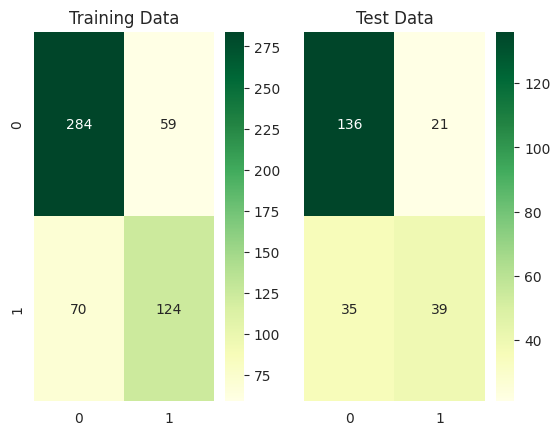

In [139]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0])
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1])
a[0][1].set_title('Test Data')

## Classification Report

In [140]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix
print(classification_report(y_train,predict_train))
print(classification_report(y_test,predict_test))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81       343
           1       0.68      0.64      0.66       194

    accuracy                           0.76       537
   macro avg       0.74      0.73      0.74       537
weighted avg       0.76      0.76      0.76       537

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       157
           1       0.65      0.53      0.58        74

    accuracy                           0.76       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.75      0.76      0.75       231



## Hyperparameter Tuning to improve Accuracy

Var_smoothing (Variance smoothing) parameter specifies the portion of the largest variance of all features to be added to variances for stability of calculation. 

Gaussian Naive Bayes assumes that features follows normal distribution which is most unlikely in real world.So solve this problem we can perform "power transformation" on each feature to make it more or less normally distributed. By default, PowerTransformer results in features that have a 0 mean and 1 standard deviation.

In [141]:
np.logspace(0,-9, num=10)

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])

In [142]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [143]:

from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, y_test)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=1)

In [144]:
gs_NB.best_params_

{'var_smoothing': 0.0533669923120631}

In [145]:
gs_NB.best_score_

0.7775208140610546

In [146]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

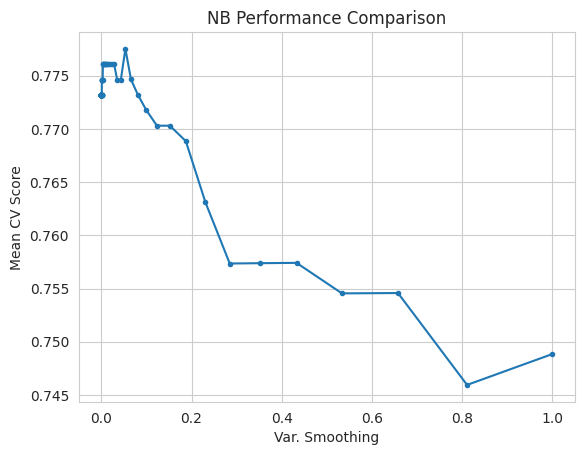

In [147]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")  
plt.show()

In [148]:
# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)


accuracy_score on test dataset :  0.7922077922077922


Text(0.5, 1.0, 'Test Data')

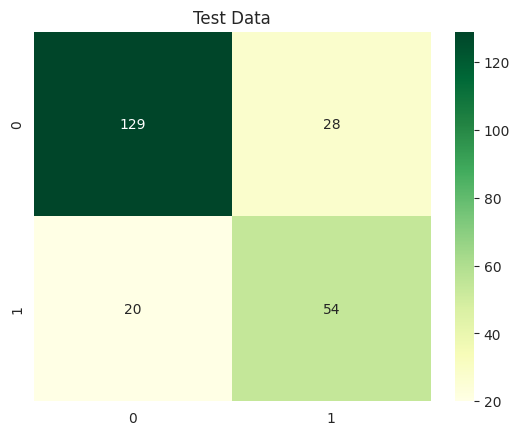

In [149]:

sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data')